#      Lab 4 - Introduction to PySpark 

##      INET4710 Spring 2020

### Submitted by: Mahsa Ayoughi


In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
!pip install -q findspark


In [0]:
import os

In [0]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

from pyspark.sql.functions import count
from pyspark.sql import functions as F

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
import pyspark.ml.evaluation as evals

import pyspark.ml.tuning as tune


##    CHAPTER 1  - Getting to know PySpark


### What is Spark

Spark is a platform for cluster computing. Spark lets you spread data and computations over clusters with multiple nodes (think of each node as a separate computer). Splitting up your data makes it easier to work with very large datasets because each node only works with a small amount of data.

As each node works on its own subset of the total data, it also carries out a part of the total calculations required, so that both data processing and computation are performed in parallel over the nodes in the cluster. It is a fact that parallel computation can make certain types of programming tasks much faster.

However, with greater computing power comes greater complexity.

Deciding whether or not Spark is the best solution for your problem takes some experience, but you can consider questions like:

Is my data too big to work with on a single machine?
Can my calculations be easily parallelized?

### Using Spark in Python

The first step in using Spark is connecting to a cluster.

In practice, the cluster will be hosted on a remote machine that's connected to all other nodes. There will be one computer, called the master that manages splitting up the data and the computations. The master is connected to the rest of the computers in the cluster, which are called slaves. The master sends the slaves data and calculations to run, and they send their results back to the master.

When you're just getting started with Spark it's simpler to just run a cluster locally. Thus, for this course, instead of connecting to another computer, all computations will be run on DataCamp's servers in a simulated cluster.

Creating the connection is as simple as creating an instance of the SparkContext class. The class constructor takes a few optional arguments that allow you to specify the attributes of the cluster you're connecting to.

An object holding all these attributes can be created with the SparkConf() constructor. Take a look at the documentation for all the details. http://spark.apache.org/docs/2.1.0/api/python/pyspark.html

For the rest of this course you'll have a SparkContext called **sc** already available in your workspace.

How do you connect to a Spark cluster from PySpark?

In [8]:
print("Create an instance of the SparkContext class.")

Create an instance of the SparkContext class.


### Examining the SparkContext

In this section you'll get familiar with the SparkContext.

You'll probably notice that code takes longer to run than you might expect. This is because Spark is some serious software. It takes more time to start up than you might be used to. You may also find that running simpler computations might take longer than expected. That's because all the optimizations that Spark has under its hood are designed for complicated operations with big data sets. That means that for simple or small problems Spark may actually perform worse than some other solutions!

In [0]:
%%script false

from pyspark import SparkContext
sc = SparkContext()

# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

### Using Dataframes

Spark's core data structure is the Resilient Distributed Dataset (RDD). This is a low level object that lets Spark work its magic by splitting data across multiple nodes in the cluster. However, RDDs are hard to work with directly, so in this course you'll be using the Spark DataFrame abstraction built on top of RDDs.

The Spark DataFrame was designed to behave a lot like a SQL table (a table with variables in the columns and observations in the rows). Not only are they easier to understand, DataFrames are also more optimized for complicated operations than RDDs.

When you start modifying and combining columns and rows of data, there are many ways to arrive at the same result, but some often take much longer than others. When using RDDs, it's up to the data scientist to figure out the right way to optimize the query, but the DataFrame implementation has much of this optimization built in!

To start working with Spark DataFrames, you first have to create a SparkSession object from your SparkContext. **You can think of the SparkContext as your connection to the cluster and the SparkSession as your interface with that connection.**

--> Remember, for the rest of this course you'll have a SparkSession called **spark** available in your workspace!

Which of the following is an advantage of Spark DataFrames over RDDs?

In [10]:
print("Operations using DataFrames are automatically optimized.")

Operations using DataFrames are automatically optimized.


### Creating a SparkSession

We've already created a SparkSession for you called **spark**, but what if you're not sure there already is one? Creating multiple SparkSessions and SparkContexts can cause issues, so it's best practice to use the SparkSession.builder.getOrCreate() method. This *returns an existing SparkSession if there's already one in the environment, or creates a new one if necessary!*

In [11]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create my_spark
spark = SparkSession.builder.getOrCreate()

# Print my_spark
print(spark)

### Viewing tables

Once you've created a SparkSession, you can start poking around to see what data is in your cluster!

Your SparkSession has an attribute called *catalog* which lists all the data inside the cluster. This attribute has a few methods for extracting different pieces of information.

One of the most useful is the .listTables() method, which returns the names of all the tables in your cluster as a list.

In [12]:
# Print the tables in the catalog
print(spark.catalog.listTables())

#  output:
#     [Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

[]


In [14]:
from google.colab import files 
files.upload()

Saving flights_small.csv to flights_small.csv


{'flights_small.csv': b'year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance,hour,minute\n2014,12,8,658,-7,935,-5,VX,N846VA,1780,SEA,LAX,132,954,6,58\n2014,1,22,1040,5,1505,5,AS,N559AS,851,SEA,HNL,360,2677,10,40\n2014,3,9,1443,-2,1652,2,VX,N847VA,755,SEA,SFO,111,679,14,43\n2014,4,9,1705,45,1839,34,WN,N360SW,344,PDX,SJC,83,569,17,5\n2014,3,9,754,-1,1015,1,AS,N612AS,522,SEA,BUR,127,937,7,54\n2014,1,15,1037,7,1352,2,WN,N646SW,48,PDX,DEN,121,991,10,37\n2014,7,2,847,42,1041,51,WN,N422WN,1520,PDX,OAK,90,543,8,47\n2014,5,12,1655,-5,1842,-18,VX,N361VA,755,SEA,SFO,98,679,16,55\n2014,4,19,1236,-4,1508,-7,AS,N309AS,490,SEA,SAN,135,1050,12,36\n2014,11,19,1812,-3,2352,-4,AS,N564AS,26,SEA,ORD,198,1721,18,12\n2014,11,8,1653,-2,1924,-1,AS,N323AS,448,SEA,LAX,130,954,16,53\n2014,8,3,1120,0,1415,2,AS,N305AS,656,SEA,PHX,154,1107,11,20\n2014,10,30,811,21,1038,29,AS,N433AS,608,SEA,LAS,127,867,8,11\n2014,11,12,2346,-4,217,-28,AS,N765AS,121,SEA,ANC,183,1448

In [15]:
data = spark.read.csv("flights_small.csv", header=True)
data.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

In [16]:
spark.read.csv("flights_small.csv", header=True)

DataFrame[year: string, month: string, day: string, dep_time: string, dep_delay: string, arr_time: string, arr_delay: string, carrier: string, tailnum: string, flight: string, origin: string, dest: string, air_time: string, distance: string, hour: string, minute: string]

In [17]:
# Create spark_temp
# spark_temp_0 = spark.createDataFrame(pd.read_csv(data_folder + "flights_small.csv"))
spark_temp_0 = spark.read.format("csv").options(header="true").load("flights_small.csv")

# Examine the tables in the catalog
print(spark.catalog.listTables(), "\n")

# Add spark_temp to the catalog
spark_temp_0.createOrReplaceTempView("flights")

# Examine the tables in the catalog again
print(spark.catalog.listTables())

[] 

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


### Queryies

One of the advantages of the DataFrame interface is that you can run SQL queries on the tables in your Spark cluster. 

As you saw in the last exercise, one of the tables in your cluster is the **flights table**. This table contains a row for every flight that left Portland International Airport (PDX) or Seattle-Tacoma International Airport (SEA) in 2014 and 2015.

Running a query on this table is as easy as using the .sql() method on your SparkSession. This method takes a string containing the query and returns a DataFrame with the results!

If you look closely, you'll notice that the table flights is only mentioned in the query, not as an argument to any of the methods. This is because there isn't a local object in your environment that holds that data, so it wouldn't make sense to pass the table as an argument.

Remember, we've already created a SparkSession called spark in your workspace. 

In [18]:
# Don't change this query
query = "SELECT * FROM flights LIMIT 10"

# Get the first 10 rows of flights
flights10 = spark.sql(query)

# Show the results
flights10.show()   # mesmo que em cima

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

In [19]:
# para ver tudo
data.select('*').show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

### Spark DataFrame

Suppose you've run a query on your huge dataset and aggregated it down to something a little more manageable.

Sometimes it makes sense to then take that table and work with it locally using a tool like pandas. Spark DataFrames make that easy with the .toPandas() method. Calling this method on a Spark DataFrame returns the corresponding pandas DataFrame. It's as simple as that!

This time the query counts the number of flights to each airport from SEA and PDX.

Remember, there's already a SparkSession called spark in your workspace!

In [20]:
# Don't change this query
query = "SELECT origin, dest, COUNT(*) as N FROM flights GROUP BY origin, dest"

# Run the query
flight_counts = spark.sql(query)

# Convert the results to a pandas DataFrame
pd_counts = flight_counts.toPandas()

# Print the head of pd_counts
print(pd_counts.head())

  origin dest    N
0    SEA  RNO    8
1    SEA  DTW   98
2    SEA  CLE    2
3    SEA  LAX  450
4    PDX  SEA  144


In [21]:
# outros
from pyspark.sql.functions import count

# vou pôr só os primeiros 5
data.select(data['origin'], data['dest']).toPandas().iloc[:5, :]

,origin,dest
0,SEA,LAX
1,SEA,HNL
2,SEA,SFO
3,PDX,SJC
4,SEA,BUR


In [22]:
from pyspark.sql.functions import count

data.agg(count("*").alias('N')).show()

+-----+
|    N|
+-----+
|10000|
+-----+



In [23]:
data.count()

10000

### Spark in your data

In the last section, you saw how to move data from Spark to pandas. However, maybe you want to go the other direction, and put a pandas DataFrame into a Spark cluster! The SparkSession class has a method for this as well.

The **.createDataFrame()** method takes a pandas DataFrame and returns a Spark DataFrame.

The output of this method is stored locally, not in the SparkSession catalog. This means that you can use all the Spark DataFrame methods on it, but you can't access the data in other contexts.

***For example, a SQL query (using the .sql() method) that references your DataFrame will throw an error. To access the data in this way, you have to save it as a temporary table.***

You can do this using the **.createTempView()** Spark DataFrame method, which takes as its only argument the name of the temporary table you'd like to register. This method registers the DataFrame as a table in the catalog, but as this table is temporary, it can only be accessed from the specific SparkSession used to create the Spark DataFrame.

There is also the method **.createOrReplaceTempView()**. This safely creates a new temporary table if nothing was there before, or updates an existing table if one was already defined. You'll use this method to avoid running into problems with duplicate tables.

Check out the diagram to see all the different ways your Spark data structures interact with each other.



There's already a SparkSession called spark in your workspace, numpy has been imported as np, and pandas as pd.

In [25]:
from google.colab import files 
files.upload()

Saving spark_figure.png to spark_figure.png


{'spark_figure.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x03\x00\x08\x06\x00\x00\x00\xba\xba\x15\r\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00@\x00IDATx\x01\xec\xdd\x07|T\xc5\xda\xc7\xf1\x87"H\xef\xbd\xf7\xdeQ@T@i* "\x16@\xd0k\xaf\xd8^{\xd7{\xed^\xdb\xb5`\xaf\x80b\x01\x04,\x14Q\x10\xe9 \xbd\xf7\xde{/\xef\xf9\x8fws\x93\xb0\t\tI6g\xf7\xfc\xe6~\xf6&\xd9\xdds\xce\xcc\xf7l03\xf3\xcc3Y\x8e{\xc5(\x08 \x80\x00\x02\x08 \x80\x00\x02\x08 \x80\x00\x02\x08 \x10\xd3\x02Yc\xbau4\x0e\x01\x04\x10@\x00\x01\x04\x10@\x00\x01\x04\x10@\x00\x01\x04\x9c\x00\x03\x00|\x10\x10@\x00\x01\x04\x10@\x00\x01\x04\x10@\x00\x01\x04\x10\x08\x80\x00\x03\x00\x01\xb8\xc94\x11\x01\x04\x10@\x00\x01\x04\x10@\x00\x01\x04\x10@\x00\x01\x06\x00\xf8\x0c \x80\x00\x02\x08 \x80\x00\x02\x08 \x80\x00\x02\x08 \x10\x00\x01\x06\x00\x02p\x93i"\x02\x08 \x80\x00\x02\x08 \x80\x00\x02\x08 \x80\x00\x02\x0c\x00\xf0\x19@\x00\x01\x04\x10@\x00\x01\x04\x10@\x00\x01\x04\x10@ \x00\x02\x0c\x00\x04\xe0&\xd3D\x04\x10@\x00\x01\

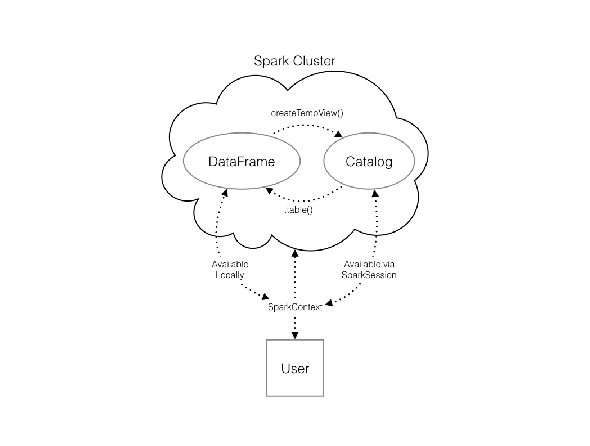

In [28]:
imagem = plt.imread("spark_figure.png")
plt.axis('off')
plt.imshow(imagem)

plt.subplots_adjust(left=0, bottom=-0.5, right=1.8, top=1, wspace=0, hspace=0)
plt.show()

In [29]:
# Create pd_temp
pd_temp = pd.DataFrame(np.random.random(10))

# Create spark_temp from pd_temp
spark_temp = spark.createDataFrame(pd_temp)

# Examine the tables in the catalog
print(spark.catalog.listTables(), "\n")

# Add spark_temp to the catalog
spark_temp.createOrReplaceTempView("temp")

# Examine the tables in the catalog again
print(spark.catalog.listTables())

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True)] 

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='temp', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


Now you know how to put data into Spark via pandas, but you're probably wondering why deal with pandas at all? Wouldn't it be easier to just read a text file straight into Spark? Of course it would!

Luckily, your SparkSession has a **.read** attribute which has several methods for reading different data sources into Spark DataFrames. Using these you can create a DataFrame from a .csv file just like with regular pandas DataFrames!

The file airports.csv contains information about different airports all over the world.

A SparkSession named spark is available in your workspace.

In [32]:
from google.colab import files 
files.upload()

Saving airports.csv to airports.csv


{'airports.csv': b'"faa","name","lat","lon","alt","tz","dst"\n"04G","Lansdowne Airport",41.1304722,-80.6195833,1044,-5,"A"\n"06A","Moton Field Municipal Airport",32.4605722,-85.6800278,264,-5,"A"\n"06C","Schaumburg Regional",41.9893408,-88.1012428,801,-6,"A"\n"06N","Randall Airport",41.431912,-74.3915611,523,-5,"A"\n"09J","Jekyll Island Airport",31.0744722,-81.4277778,11,-4,"A"\n"0A9","Elizabethton Municipal Airport",36.3712222,-82.1734167,1593,-4,"A"\n"0G6","Williams County Airport",41.4673056,-84.5067778,730,-5,"A"\n"0G7","Finger Lakes Regional Airport",42.8835647,-76.7812318,492,-5,"A"\n"0P2","Shoestring Aviation Airfield",39.7948244,-76.6471914,1000,-5,"U"\n"0S9","Jefferson County Intl",48.0538086,-122.8106436,108,-8,"A"\n"0W3","Harford County Airport",39.5668378,-76.2024028,409,-5,"A"\n"10C","Galt Field Airport",42.4028889,-88.3751111,875,-6,"U"\n"17G","Port Bucyrus-Crawford County Airport",40.7815556,-82.9748056,1003,-5,"A"\n"19A","Jackson County Airport",34.1758638,-83.5615972,9

In [33]:
# Read in the airports data
airports = spark.read.csv("airports.csv", header=True)

# Show the data
airports.show()

+---+--------------------+----------------+-----------------+----+---+---+
|faa|                name|             lat|              lon| alt| tz|dst|
+---+--------------------+----------------+-----------------+----+---+---+
|04G|   Lansdowne Airport|      41.1304722|      -80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|      32.4605722|      -85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|      41.9893408|      -88.1012428| 801| -6|  A|
|06N|     Randall Airport|       41.431912|      -74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|      31.0744722|      -81.4277778|  11| -4|  A|
|0A9|Elizabethton Muni...|      36.3712222|      -82.1734167|1593| -4|  A|
|0G6|Williams County A...|      41.4673056|      -84.5067778| 730| -5|  A|
|0G7|Finger Lakes Regi...|      42.8835647|      -76.7812318| 492| -5|  A|
|0P2|Shoestring Aviati...|      39.7948244|      -76.6471914|1000| -5|  U|
|0S9|Jefferson County ...|      48.0538086|     -122.8106436| 108| -8|  A|
|0W3|Harford County Ai...

# CHAPTER 2 - Manipulating data

### Creating columns

In this chapter, you'll learn how to use the methods defined by Spark's DataFrame class to perform common data operations.

Let's look at performing column-wise operations. In Spark you can do this using the **.withColumn()** method, which takes two arguments. First, a string with the name of your new column, and second the new column itself.

The new column must be an object of class Column. Creating one of these is as easy as extracting a column from your DataFrame using df.colName.

Updating a Spark DataFrame is somewhat different than working in pandas because the Spark DataFrame is immutable. This means that it can't be changed, and so columns can't be updated in place.

Thus, all these methods return a new DataFrame. To overwrite the original DataFrame you must reassign the returned DataFrame using the method like so:

**df = df.withColumn("newCol", df.oldCol + 1)**

The above code creates a DataFrame with the same columns as df plus a new column, newCol, where every entry is equal to the corresponding entry from oldCol, plus one.

To overwrite an existing column, just pass the name of the column as the first argument!

Remember, a SparkSession called spark is already in your workspace.

In [38]:
# Create the DataFrame flights
flights = spark.table("flights")

# Show the head
flights.show()

# Add duration_hrs
flights = flights.withColumn("duration_hrs", flights.air_time/60)

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+
|2014|   12|  8|     658|       -7|     935|       -5|     VX| N846VA|  1780|   SEA| LAX|     132|     954|   6|    58|
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|
|2014|    3|  9|    1443|       -2|    1652|        2|     VX| N847VA|   755|   SEA| SFO|     111|     679|  14|    43|
|2014|    4|  9|    1705|       45|    1839|       34|     WN| N360SW|   344|   PDX| SJC|      83|     569|  17|     5|
|2014|    3|  9|     754|       -1|    1015|        1|     AS| N612AS|   522|   SEA| BUR|     127|     937|   7|    54|
|2014|    1| 15|    1037|        7|    1

### SQL in a nutshell

Which of the following queries returns a table of tail numbers and destinations for flights that lasted more than 10 hours?

In [39]:
print("SELECT dest, tail_num FROM flights WHERE air_time > 600")

SELECT dest, tail_num FROM flights WHERE air_time > 600


What information would this query get? Remember the flights table holds information about flights that departed PDX and SEA in 2014 and 2015. Note that AVG() function gets the average value of a column!

**SELECT AVG(air_time) / 60 FROM flights
GROUP BY origin, carrier**

In [40]:
print("The average length of each airline's flights from SEA and from PDX in hours")

The average length of each airline's flights from SEA and from PDX in hours


### Filtering data

Now that you have a bit of SQL know-how under your belt, it's easier to talk about the analogous operations using Spark DataFrames.

Let's take a look at the **.filter()** method. As you might suspect, this is the Spark counterpart of SQL's **WHERE** clause. The .filter() method takes either a Spark Column of boolean (True/False) values or the WHERE clause of a SQL expression as a string.

For example, the following two expressions will produce the same output:

**flights.filter(flights.air_time > 120).show()**

**flights.filter("air_time > 120").show()**

Remember, a SparkSession called spark is already in your workspace, along with the Spark DataFrame flights.

In [41]:
# Filter flights with a SQL string
long_flights1 = flights.filter("distance > 1000")

# Filter flights with a boolean column
long_flights2 = flights.filter(flights.distance > 1000)

# Examine the data to check they're equal
long_flights1.show()
print("\n")
long_flights2.show()

+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|year|month|day|dep_time|dep_delay|arr_time|arr_delay|carrier|tailnum|flight|origin|dest|air_time|distance|hour|minute|      duration_hrs|
+----+-----+---+--------+---------+--------+---------+-------+-------+------+------+----+--------+--------+----+------+------------------+
|2014|    1| 22|    1040|        5|    1505|        5|     AS| N559AS|   851|   SEA| HNL|     360|    2677|  10|    40|               6.0|
|2014|    4| 19|    1236|       -4|    1508|       -7|     AS| N309AS|   490|   SEA| SAN|     135|    1050|  12|    36|              2.25|
|2014|   11| 19|    1812|       -3|    2352|       -4|     AS| N564AS|    26|   SEA| ORD|     198|    1721|  18|    12|               3.3|
|2014|    8|  3|    1120|        0|    1415|        2|     AS| N305AS|   656|   SEA| PHX|     154|    1107|  11|    20| 2.566666666666667|
|2014|   11| 12|    2346|  

### Selecting

The Spark variant of SQL's SELECT is the **.select()** method. This method takes multiple arguments - one for each column you want to select. These arguments can either be the column name as a string (one for each column) or a column object (using the df.colName syntax). When you pass a column object, you can perform operations like addition or subtraction on the column to change the data contained in it, much like inside .withColumn().

**The difference between .select() and .withColumn() methods is that .select() returns only the columns you specify, while .withColumn() returns all the columns of the DataFrame in addition to the one you defined.** It's often a good idea to drop columns you don't need at the beginning of an operation so that you're not dragging around extra data as you're wrangling. In this case, you would use .select() and not .withColumn().

Remember, a SparkSession called spark is already in your workspace, along with the Spark DataFrame flights.

In [42]:
# Select the first set of columns (tailnum, origin, and dest from flights)
selected1 = flights.select('tailnum', 'origin', 'dest')

# Select the second set of columns (origin, dest, and carrier using the df.colName syntax)
temp = flights.select(flights.origin, flights.dest, flights.carrier)

# Define first filter
filterA = flights.origin == "SEA"

# Define second filter
filterB = flights.dest == "PDX"

# Filter the data, first by filterA then by filterB
selected2 = temp.filter(filterA).filter(filterB)

selected2.show()

+------+----+-------+
|origin|dest|carrier|
+------+----+-------+
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     AS|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     AS|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
|   SEA| PDX|     OO|
+------+----+-------+
only showing top 20 rows



### Selecting (2)

Similar to SQL, you can also use the **.select()** method to perform column-wise operations. When you're selecting a column using the df.colName notation, you can perform any column operation and the .select() method will return the transformed column. For example,

**flights.select(flights.air_time/60)**

returns a column of flight durations in hours instead of minutes. You can also use the **.alias()** method to rename a column you're selecting. So if you wanted to .select() the column duration_hrs (which isn't in your DataFrame) you could do

**flights.select((flights.air_time/60).alias("duration_hrs"))**

The equivalent Spark DataFrame method **.selectExpr()** takes SQL expressions as a string:

**flights.selectExpr("air_time/60 as duration_hrs")**

with the SQL as keyword being equivalent to the .alias() method. To select multiple columns, you can pass multiple strings.

Remember, a SparkSession called spark is already in your workspace, along with the Spark DataFrame flights.

In [43]:
# Define avg_speed
avg_speed = (flights.distance/(flights.air_time/60)).alias("avg_speed")

# Select the correct columns
speed1 = flights.select("origin", "dest", "tailnum", avg_speed)

# Create the same table using a SQL expression
speed2 = flights.selectExpr("origin", "dest", "tailnum", "distance/(air_time/60) as avg_speed")


speed1.show()

+------+----+-------+------------------+
|origin|dest|tailnum|         avg_speed|
+------+----+-------+------------------+
|   SEA| LAX| N846VA| 433.6363636363636|
|   SEA| HNL| N559AS| 446.1666666666667|
|   SEA| SFO| N847VA|367.02702702702703|
|   PDX| SJC| N360SW| 411.3253012048193|
|   SEA| BUR| N612AS| 442.6771653543307|
|   PDX| DEN| N646SW|491.40495867768595|
|   PDX| OAK| N422WN|             362.0|
|   SEA| SFO| N361VA| 415.7142857142857|
|   SEA| SAN| N309AS| 466.6666666666667|
|   SEA| ORD| N564AS| 521.5151515151515|
|   SEA| LAX| N323AS| 440.3076923076923|
|   SEA| PHX| N305AS|431.29870129870125|
|   SEA| LAS| N433AS| 409.6062992125984|
|   SEA| ANC| N765AS|474.75409836065575|
|   SEA| SFO| N713AS| 315.8139534883721|
|   PDX| SFO| N27205| 366.6666666666667|
|   SEA| SMF| N626AS|477.63157894736844|
|   SEA| MDW| N8634A|481.38888888888886|
|   SEA| BOS| N597AS| 516.4137931034483|
|   PDX| BUR| N215AG| 441.6216216216216|
+------+----+-------+------------------+
only showing top

### Aggregating

All of the common aggregation methods, like **.min()**, **.max()**, and **.count()** are GroupedData methods. These are created by calling the **.groupBy() DataFrame method**. You'll learn exactly what that means in a few exercises. For now, all you have to do to use these functions is call that method on your DataFrame. For example, to find the minimum value of a column, col, in a DataFrame, df, you could do

**df.groupBy().min("col").show()**

This creates a GroupedData object (so you can use the .min() method), then finds the minimum value in col, and returns it as a DataFrame.

Now you're ready to do some aggregating of your own.

A SparkSession called spark is already in your workspace, along with the Spark DataFrame flights.

In [0]:
%%script false
# Find the shortest flight from PDX in terms of distance
flights.filter(flights.origin == "PDX").groupBy().min("distance").show()

# Find the longest flight from SEA in terms of air time
flights.filter(flights.origin == "SEA").groupBy().max("air_time").show()

In [45]:
from pyspark.sql import functions as F

# Find the shortest flight from PDX in terms of distance
flights.filter(flights.origin == "PDX").agg(F.min("distance")).show()    # não deu igual

# Find the longest flight from SEA in terms of air time
flights.filter(flights.origin == "SEA").agg(F.max("air_time")).show()    # não deu igual

+-------------+
|min(distance)|
+-------------+
|         1009|
+-------------+

+-------------+
|max(air_time)|
+-------------+
|           NA|
+-------------+



### Aggregating (2)

In [0]:
%%script false
# Average duration of Delta flights
flights.filter(flights.carrier == "DL").filter(flights.origin == "SEA").groupBy().avg("air_time").show()

# Total hours in the air
flights.withColumn("duration_hrs", flights.air_time/60).groupBy().sum("duration_hrs").show()

In [48]:
# Average duration of Delta flights
flights.filter(flights.carrier == "DL").filter(flights.origin == "SEA").agg(F.avg("air_time")).show()

# Total hours in the air
flights.withColumn("duration_hrs", flights.air_time/60).agg(F.sum("duration_hrs")).show()

+------------------+
|     avg(air_time)|
+------------------+
|188.20689655172413|
+------------------+

+------------------+
| sum(duration_hrs)|
+------------------+
|25289.600000000126|
+------------------+



### Grouping and Aggregating

Part of what makes aggregating so powerful is the addition of groups. PySpark has a whole class devoted to grouped data frames: **pyspark.sql.GroupedData**, which you saw in the last two exercises.

You've learned how to create a grouped DataFrame by calling the .groupBy() method on a DataFrame with no arguments.

Now you'll see that when you pass the name of one or more columns in your DataFrame to the .groupBy() method, the aggregation methods behave like when you use a GROUP BY statement in a SQL query!

Remember, a SparkSession called spark is already in your workspace, along with the Spark DataFrame flights.

In [49]:
# Group by tailnum
by_plane = flights.groupBy("tailnum")

# Number of flights each plane made
by_plane.count().show()

# Group by origin
by_origin = flights.groupBy("origin")

# Average duration of flights from PDX and SEA
by_origin.agg(F.avg("air_time")).show()        # simplesmente com   by_origin.avg("air_time").show()   dá erro

+-------+-----+
|tailnum|count|
+-------+-----+
| N442AS|   38|
| N102UW|    2|
| N36472|    4|
| N38451|    4|
| N73283|    4|
| N513UA|    2|
| N954WN|    5|
| N388DA|    3|
| N567AA|    1|
| N516UA|    2|
| N927DN|    1|
| N8322X|    1|
| N466SW|    1|
|  N6700|    1|
| N607AS|   45|
| N622SW|    4|
| N584AS|   31|
| N914WN|    4|
| N654AW|    2|
| N336NW|    1|
+-------+-----+
only showing top 20 rows

+------+------------------+
|origin|     avg(air_time)|
+------+------------------+
|   SEA| 160.4361496051259|
|   PDX|137.11543248288737|
+------+------------------+



### Grouping and Aggregating (2)

In addition to the GroupedData methods you've already seen, there is also the **.agg()** method. This method lets you pass an aggregate column expression that uses any of the aggregate functions from the **pyspark.sql.functions** submodule.

This submodule contains many useful functions for computing things like standard deviations. All the aggregation functions in this submodule take the name of a column in a GroupedData table.

Remember, a SparkSession called spark is already in your workspace, along with the Spark DataFrame flights. The grouped DataFrames you created in the last exercise are also in your workspace.

In [50]:
# Import pyspark.sql.functions as F
import pyspark.sql.functions as F

# Group by month and dest
by_month_dest = flights.groupBy('month', 'dest')

# Average departure delay by month and destination
by_month_dest.agg(F.avg('dep_delay')).show()

# Standard deviation of departure delay
by_month_dest.agg(F.stddev('dep_delay')).show()

+-----+----+--------------------+
|month|dest|      avg(dep_delay)|
+-----+----+--------------------+
|   11| TUS| -2.3333333333333335|
|   11| ANC|   7.529411764705882|
|    1| BUR|               -1.45|
|    1| PDX| -5.6923076923076925|
|    6| SBA|                -2.5|
|    5| LAX|-0.15789473684210525|
|   10| DTW|                 2.6|
|    6| SIT|                -1.0|
|   10| DFW|  18.176470588235293|
|    3| FAI|                -2.2|
|   10| SEA|                -0.8|
|    2| TUS| -0.6666666666666666|
|   12| OGG|  25.181818181818183|
|    9| DFW|   4.066666666666666|
|    5| EWR|               14.25|
|    3| RDM|                -6.2|
|    8| DCA|                 2.6|
|    7| ATL|   4.675675675675675|
|    4| JFK| 0.07142857142857142|
|   10| SNA| -1.1333333333333333|
+-----+----+--------------------+
only showing top 20 rows

+-----+----+----------------------+
|month|dest|stddev_samp(dep_delay)|
+-----+----+----------------------+
|   11| TUS|    3.0550504633038935|
|   11| ANC|  

### Joining

Another very common data operation is the join. A join will combine two different tables along a column that they share. This column is called the key. Examples of keys here include the tailnum and carrier columns from the flights table.

For example, suppose that you want to know more information about the plane that flew a flight than just the tail number. This information isn't in the flights table because the same plane flies many different flights over the course of two years, so including this information in every row would result in a lot of duplication. To avoid this, you'd have a second table that has only one row for each plane and whose columns list all the information about the plane, including its tail number. You could call this table planes

When you join the flights table to this table of airplane information, you're adding all the columns from the planes table to the flights table. To fill these columns with information, you'll look at the tail number from the flights table and find the matching one in the planes table, and then use that row to fill out all the new columns.

Now you'll have a much bigger table than before, but now every row has all information about the plane that flew that flight!

Which of the following is ***not*** true?

In [51]:
print("there is only one kind of join.")

there is only one kind of join.


### Joining (2)

In PySpark, joins are performed using the DataFrame method **.join()**. This method takes three arguments. The first is the **second DataFrame** that you want to join with the first one. The second argument, **on**, is the name of the key column(s) as a string. The names of the key column(s) must be the same in each table. The third argument, how, specifies the kind of join to perform. In this course we'll always use the value **how="leftouter"**.

The flights dataset and a new dataset called airports are already in your workspace.

In [52]:
# Examine the data
print(airports.show())
print("\n")

# Rename the faa column
airports = airports.withColumnRenamed("faa", "dest")

# Join the DataFrames
flights_with_airports = flights.join(airports, on='dest', how="leftouter")

# Examine the new DataFrame
print(flights_with_airports.show())

+---+--------------------+----------------+-----------------+----+---+---+
|faa|                name|             lat|              lon| alt| tz|dst|
+---+--------------------+----------------+-----------------+----+---+---+
|04G|   Lansdowne Airport|      41.1304722|      -80.6195833|1044| -5|  A|
|06A|Moton Field Munic...|      32.4605722|      -85.6800278| 264| -5|  A|
|06C| Schaumburg Regional|      41.9893408|      -88.1012428| 801| -6|  A|
|06N|     Randall Airport|       41.431912|      -74.3915611| 523| -5|  A|
|09J|Jekyll Island Air...|      31.0744722|      -81.4277778|  11| -4|  A|
|0A9|Elizabethton Muni...|      36.3712222|      -82.1734167|1593| -4|  A|
|0G6|Williams County A...|      41.4673056|      -84.5067778| 730| -5|  A|
|0G7|Finger Lakes Regi...|      42.8835647|      -76.7812318| 492| -5|  A|
|0P2|Shoestring Aviati...|      39.7948244|      -76.6471914|1000| -5|  U|
|0S9|Jefferson County ...|      48.0538086|     -122.8106436| 108| -8|  A|
|0W3|Harford County Ai...